# Prep

## Change colour of graphs depending on background colour of IDE

In [1]:
# set_colour_based_on_backgrnd = 'white'
set_colour_based_on_backgrnd = 'black'


## Importing the libraries

In [48]:
import numpy as np
import pandas as pd

from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn import preprocessing

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import copy
import regex as re

In [3]:
if set_colour_based_on_backgrnd == 'black':
    plt.style.use('dark_background')
elif set_colour_based_on_backgrnd == 'white':
    plt.style.use('default')


## Reading the dataset & prep

In [51]:
cars_dataset = pd.read_csv("cars_coded.csv")

In [5]:
cars_dataset = cars_dataset.drop(['savings_amount'], axis=1)

## Process data

In [6]:
def process(df):
    cars_coded = df.copy(deep=True)
    temp_df = cars_coded.drop(['price'], axis=1)
    col_names = list(temp_df.columns)
    print('len(col_names) =', len(col_names))
    cars_array = cars_coded.to_numpy()

    return cars_array, col_names

In [7]:
cars_array,col_names = process(cars_dataset)

len(col_names) = 149


### Splitting the dataset into train and test sets

In [8]:
random_state = 2023

x =  cars_array[:, :-1]
y =  cars_array[:,-1]

x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size=0.4, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)

# Validate size (as %) of sets
print("Train size: %.3f" % (x_train.shape[0]/ x.shape[0]))
print("Validation size: %.3f" % (x_val.shape[0]/ x.shape[0]))
print("Test size: %.3f" % (x_test.shape[0]/ x.shape[0]))


Train size: 0.600
Validation size: 0.200
Test size: 0.200


Prep MPSE function

In [9]:
def mape(actual, predicted):
    return sum(abs((actual - predicted) / actual)) / len(actual)

In [10]:
# Prep for BV-graph

num_test = 20
np.random.seed(random_state)
cnt= 50
select_index = [np.random.choice(len(x_test)-1,cnt) for i in range(num_test)]

### Scaling the train and test sets using Robust and Standard Scaler

Robust and Standard scaling helps with eliminating the outliers, normalizing, and standardizing the datasets

In [11]:
def scaling(x, y):
    scale = preprocessing.RobustScaler()
    x_t1 = scale.fit_transform(x, y)
    
    scale = preprocessing.StandardScaler()
    x_t2 = scale.fit_transform(x_t1, y)
    
    return(x_t2)

In [12]:
x_train_scaled = scaling(x_train, y_train)
x_test_scaled = scaling(x_test, y_test)
x_val_scaled = scaling(x_val, y_val)

In [13]:
x_train_scaled.shape

(952025, 149)

In [14]:
def scaling_std(x, y):
    scale = preprocessing.RobustScaler()
    return scale.fit_transform(x, y)

x_train_scaledstd = scaling_std(x_train, y_train)
x_test_scaledstd = scaling_std(x_test, y_test)
x_val_scaledstd = scaling_std(x_val, y_val)

# Decision Tree Analysis (Linear Regression)

### Run DT on NOT scaled variables

In [180]:
dt_notscaled = tree.DecisionTreeRegressor(random_state = random_state)
dt_notscaled.fit(x_train, y_train)

DecisionTreeRegressor(random_state=2023)

In [181]:
y_pred_dt_notscaled = dt_notscaled.predict(x_val)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_notscaled)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_notscaled))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_notscaled))


RMSE: 9411.820947
R^2: 0.639744
MAPE: 0.103159


Mean Error, x = 10203.906000  y = 10203.906000
Mean Var Error, x = 221546393.422010  y = 221546393.422010


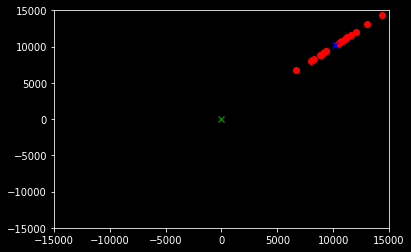

In [182]:
# Prep for BV-graph
plotsize = (-15000,15000)

# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - dt_notscaled.predict(x_val_scaled[select_index[i],:])
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(plotsize[0], plotsize[1])
plt.ylim(plotsize[0], plotsize[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

### Run DT on scaled variables (STD)

In [183]:
dt_scaledstd = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaledstd.fit(x_train_scaledstd, y_train)

DecisionTreeRegressor(random_state=2023)

In [184]:
y_pred_dt_scaledstd = dt_scaledstd.predict(x_val_scaledstd)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaledstd)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaledstd))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaledstd))


RMSE: 8153.841152
R^2: 0.729611
MAPE: 0.104714


Mean Error, x = -184.934476  y = -184.934476
Mean Var Error, x = 17826335.368777  y = 17826335.368777


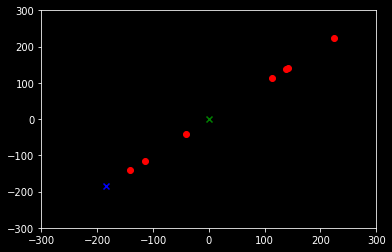

In [185]:
# Prep for BV-graph
plotsize = (-300,300)

# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaledstd[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(plotsize[0], plotsize[1])
plt.ylim(plotsize[0], plotsize[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )


### Run DT on scaled variables (Robust + STD)

In [186]:
dt_scaled = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled.fit(x_train_scaled, y_train)

DecisionTreeRegressor(random_state=2023)

In [187]:
y_pred_dt_scaled = dt_scaled.predict(x_val_scaled)
print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled))


RMSE: 6787.011938
R^2: 0.812664
MAPE: 0.112231


Mean Error, x = -311.033809  y = -311.033809
Mean Var Error, x = 21661116.901761  y = 21661116.901761


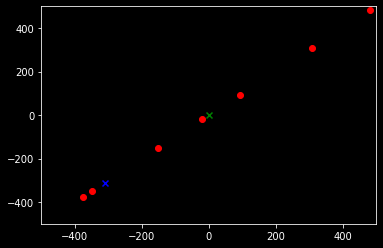

In [188]:
# Prep for BV-graph
plotsize = (-500,500)

# Create Bias-Variance graph for DT1

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(plotsize[0], plotsize[1])
plt.ylim(plotsize[0], plotsize[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled = np.mean(error[:,0])
mean_var_error_dt_scaled =np.mean(var[:,0])

## Run feature importance analysis on DT on scaled variables (RBST + STD)

(0.0, 0.6)

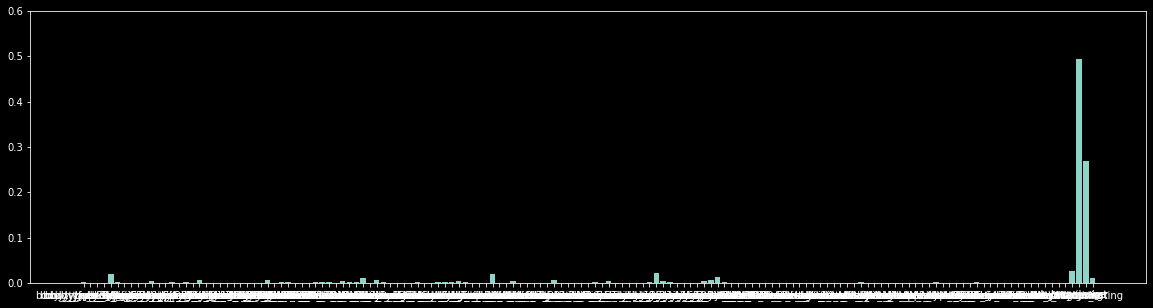

In [189]:
#all features
f = plt.subplots(figsize=(20,5))
plt.bar(col_names[:],list(dt_scaled.feature_importances_[:]))
plt.ylim(0,0.6)

Note: low feature importance noted likely because the one-hot encoding makes for sparse data. Hence zoom in on high feature importance variables.

(0.0, 0.1)

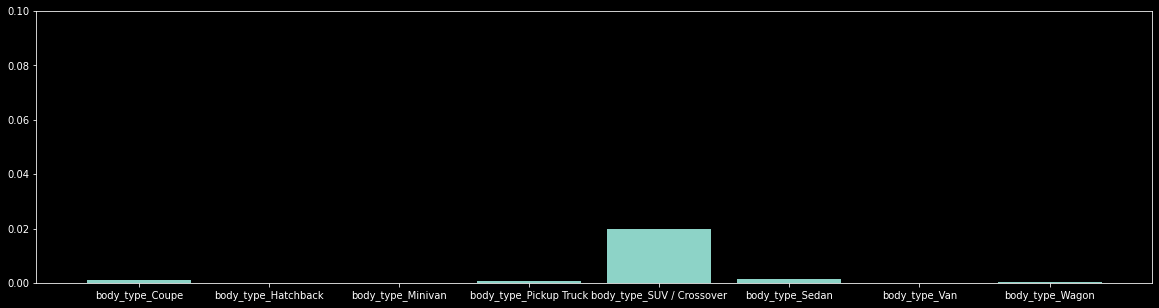

In [190]:
# body type
left, right = 0, 8

f = plt.subplots(figsize=(20,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

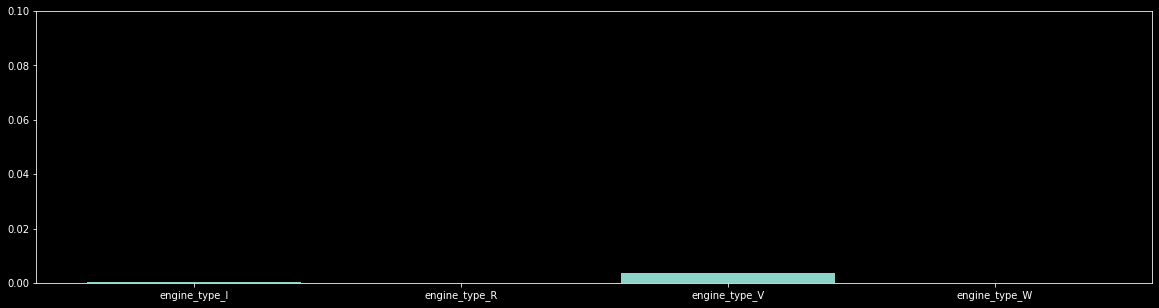

In [191]:
# engine type
left, right = 8, 12

f = plt.subplots(figsize=(20,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

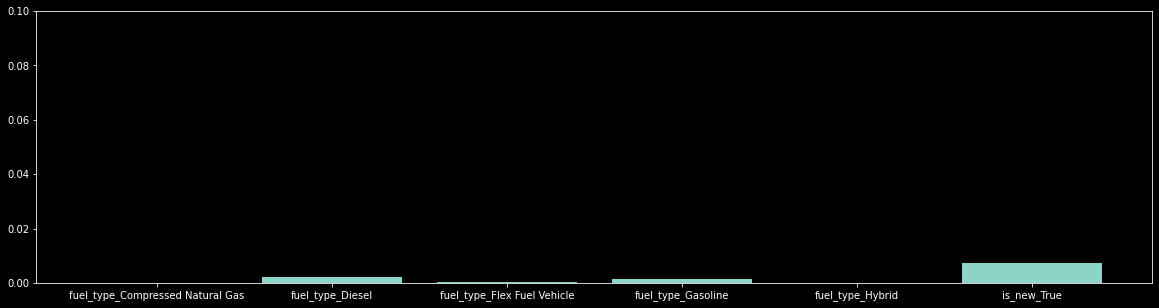

In [192]:
# fuel type & is_new_True
left, right = 12, 18

f = plt.subplots(figsize=(20,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

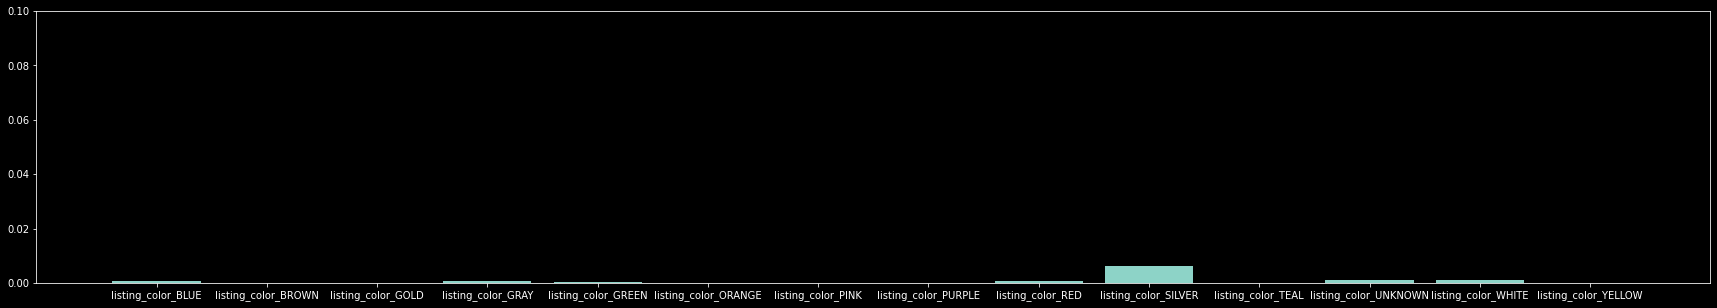

In [193]:
# listing_color
left, right = 18,32

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

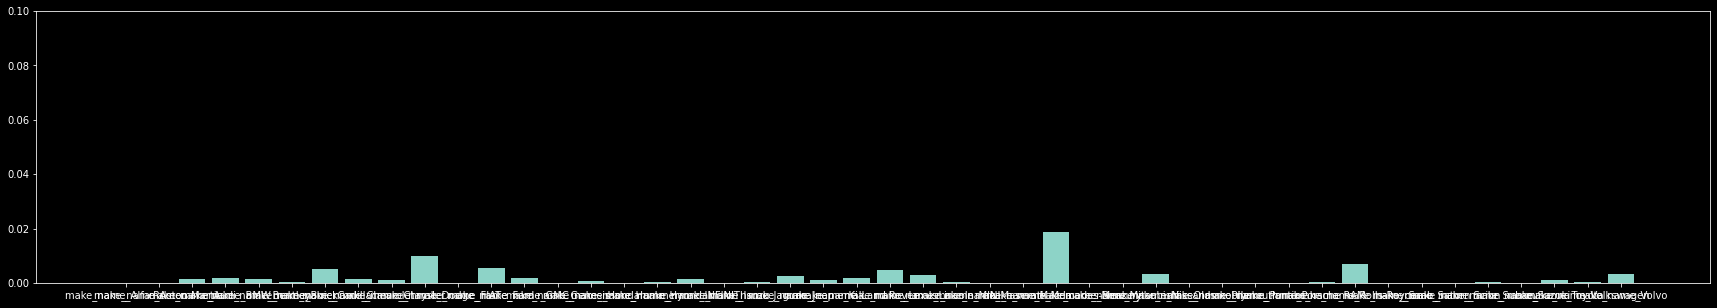

In [194]:
# make_name
left, right = 32,78

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

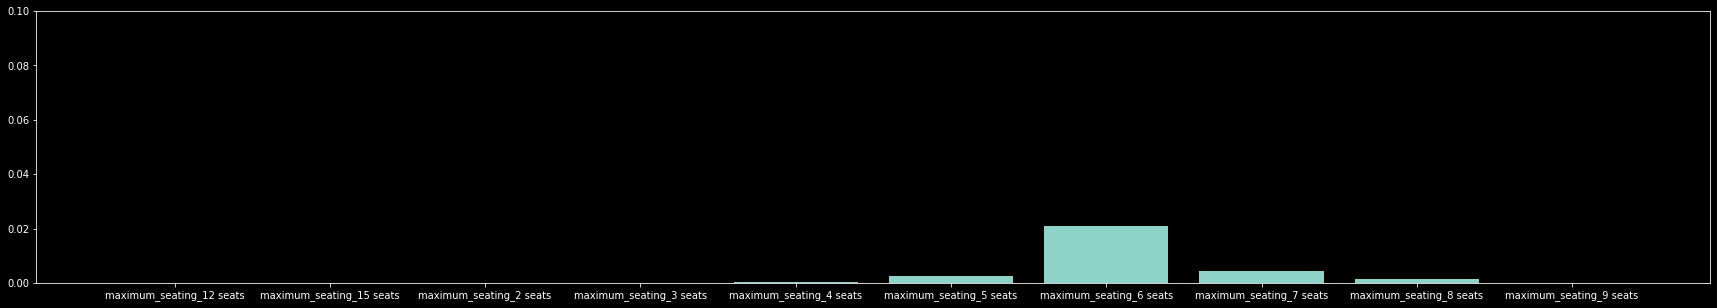

In [195]:
# maximum_seating
left, right = 78,88

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

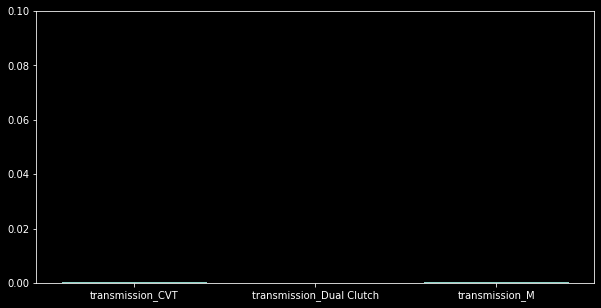

In [196]:
# transmission
left, right = 88,91

f = plt.subplots(figsize=(10,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

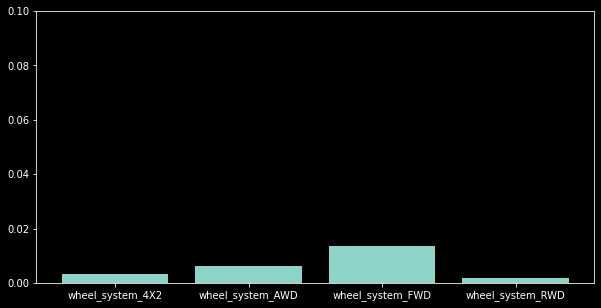

In [197]:
# wheel_system
left, right = 91,95

f = plt.subplots(figsize=(10,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.1)

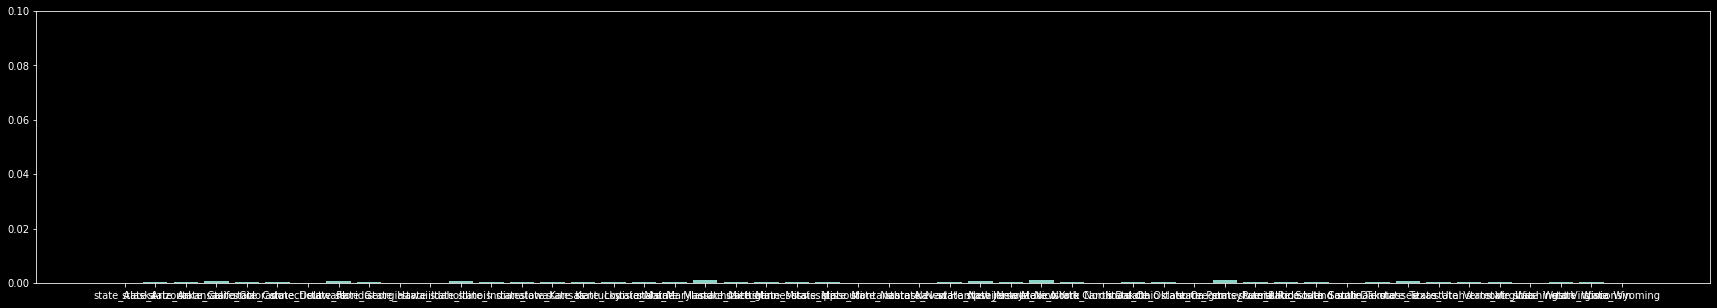

In [198]:
# state
left, right = 95,145

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:right],list(dt_scaled.feature_importances_[left:right]))
plt.ylim(0,0.1)

(0.0, 0.6)

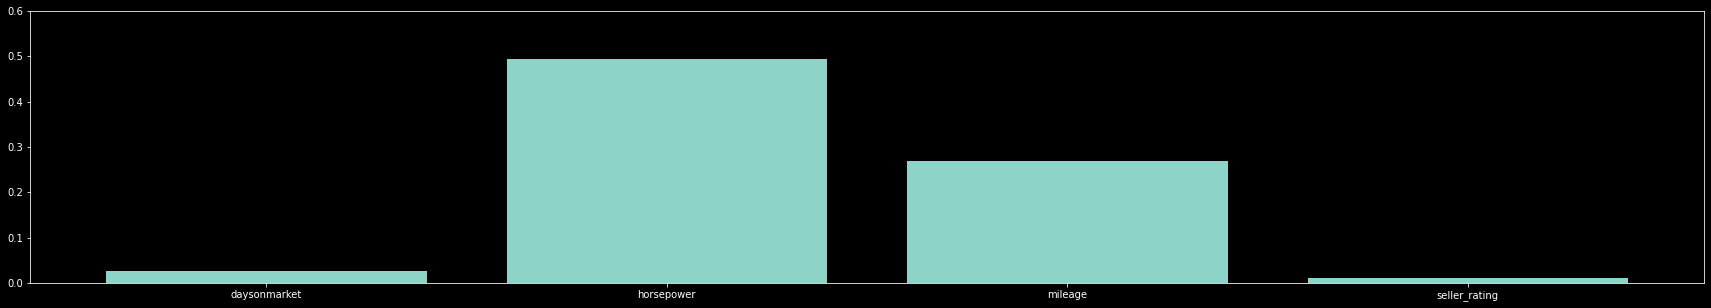

In [199]:
# continuous variables
left = 145

f = plt.subplots(figsize=(30,5))
plt.bar(col_names[left:],list(dt_scaled.feature_importances_[left:]))
plt.ylim(0,0.6)

## Omit variables based on feature importance results

In [15]:
def omit_var(start_idx, end_idx, data):
    idx_list = [idx for idx in range(start_idx,end_idx +1)]
    return np.delete(data, idx_list, axis=1)

omitted_cols = []

In [29]:
standard_plot_size = (-1000,1000)

### Omit tranmission variable

In [16]:
# check col indexes
print(col_names[90], col_names[88])

transmission_M transmission_CVT


In [203]:
print(col_names[88:90+1])

['transmission_CVT', 'transmission_Dual Clutch', 'transmission_M']


In [17]:
# omit columns
col_names2 = copy.deepcopy(col_names)
start_idx, end_idx = 88, 90

x_test_scaled2 = omit_var(start_idx, end_idx, x_test_scaled)
x_train_scaled2 = omit_var(start_idx, end_idx, x_train_scaled)
x_val_scaled2 = omit_var(start_idx, end_idx, x_val_scaled)

remove = ['transmission_CVT', 'transmission_Dual Clutch', 'transmission_M']
for i in remove:
    col_names2.remove(i)
omitted_cols += [(start_idx, end_idx)]

In [205]:
x_val_scaled2.shape

(317342, 146)

##### Run DT Regression

In [206]:
dt_scaled_2 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_2.fit(x_train_scaled2, y_train)

DecisionTreeRegressor(random_state=2023)

In [207]:
y_pred_dt_scaled_2 = dt_scaled_2.predict(x_val_scaled2)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_2)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_2))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_2))


RMSE: 6803.654947
R^2: 0.811744
MAPE: 0.112848


Mean Error, x = -266.134609  y = -266.134609
Mean Var Error, x = 20650338.287766  y = 20650338.287766


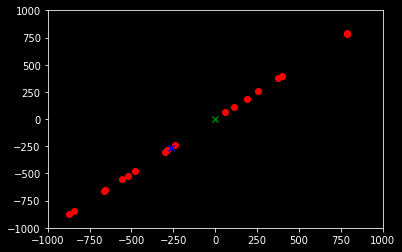

In [208]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_2[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_2 = np.mean(error[:,0])
mean_var_error_dt_scaled_2 =np.mean(var[:,0])

### Omit fuel_type variable

In [209]:
# check col indexes
print(col_names2[12],"/" , col_names2[16])

fuel_type_Compressed Natural Gas / fuel_type_Hybrid


In [210]:
print(col_names2[12:16+1])

['fuel_type_Compressed Natural Gas', 'fuel_type_Diesel', 'fuel_type_Flex Fuel Vehicle', 'fuel_type_Gasoline', 'fuel_type_Hybrid']


In [18]:
# omit columns
col_names3 = copy.deepcopy(col_names2)
start_idx, end_idx = 12, 16

x_test_scaled3 = omit_var(start_idx, end_idx, x_test_scaled2)
x_train_scaled3 = omit_var(start_idx, end_idx, x_train_scaled2)
x_val_scaled3 = omit_var(start_idx, end_idx, x_val_scaled2)

remove = ['fuel_type_Compressed Natural Gas', 'fuel_type_Diesel', 'fuel_type_Flex Fuel Vehicle', 'fuel_type_Gasoline', 'fuel_type_Hybrid']
for i in remove:
    col_names3.remove(i)
omitted_cols += [(start_idx, end_idx)]

In [212]:
x_val_scaled3.shape

(317342, 141)

##### Run DT Regression

In [213]:
dt_scaled_3 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_3.fit(x_train_scaled3, y_train)

DecisionTreeRegressor(random_state=2023)

In [214]:
y_pred_dt_scaled_3 = dt_scaled_3.predict(x_val_scaled3)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_3)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_3))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_3))


RMSE: 6820.474784
R^2: 0.810812
MAPE: 0.113254


Mean Error, x = -154.551042  y = -154.551042
Mean Var Error, x = 19750958.856510  y = 19750958.856510


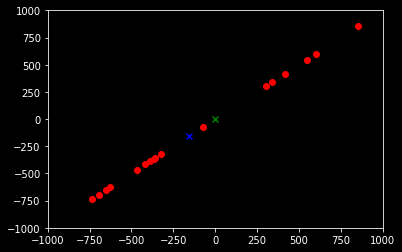

In [215]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_3[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_3 = np.mean(error[:,0])
mean_var_error_dt_scaled_3 =np.mean(var[:,0])

### Omit (some) maximum_seating variable

In [216]:
# check col indexes
print(col_names3[73] , "/", col_names3[76])
print(col_names3[82])

maximum_seating_12 seats / maximum_seating_3 seats
maximum_seating_9 seats


In [217]:
print(col_names3[73:76+1] )

['maximum_seating_12 seats', 'maximum_seating_15 seats', 'maximum_seating_2 seats', 'maximum_seating_3 seats']


In [19]:
# omit columns
col_names4 = copy.deepcopy(col_names3)
start_idx, end_idx = 82,82

x_test_scaled4 = omit_var(start_idx, end_idx, x_test_scaled3)
x_train_scaled4 = omit_var(start_idx, end_idx, x_train_scaled3)
x_val_scaled4 = omit_var(start_idx, end_idx, x_val_scaled3)

omitted_cols += [(start_idx, end_idx)]

In [219]:
x_train_scaled4.shape

(952025, 140)

In [20]:
# omit columns
start_idx, end_idx = 73,76

x_test_scaled4 = omit_var(start_idx, end_idx, x_test_scaled4)
x_train_scaled4 = omit_var(start_idx, end_idx, x_train_scaled4)
x_val_scaled4 = omit_var(start_idx, end_idx, x_val_scaled4)

remove = ['maximum_seating_12 seats', 'maximum_seating_15 seats', 'maximum_seating_2 seats', 'maximum_seating_3 seats','maximum_seating_9 seats']
for i in remove:
    col_names4.remove(i)
omitted_cols += [(start_idx, end_idx)]

##### Run DT Regression

In [221]:
dt_scaled_4 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_4.fit(x_train_scaled4, y_train)

DecisionTreeRegressor(random_state=2023)

In [222]:
y_pred_dt_scaled_4 = dt_scaled_4.predict(x_val_scaled4)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_4)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_4))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_4))

RMSE: 6826.025621
R^2: 0.810504
MAPE: 0.113368


Mean Error, x = -138.586642  y = -138.586642
Mean Var Error, x = 19287497.065859  y = 19287497.065859


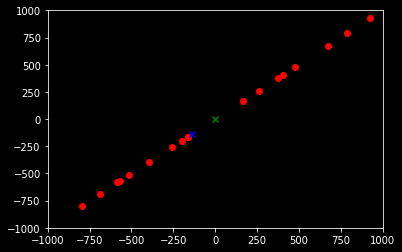

In [223]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_4[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_4 = np.mean(error[:,0])
mean_var_error_dt_scaled_4 =np.mean(var[:,0])

### Omit engine_type variable

In [224]:
# check col indexes
print(col_names4[8], "/", col_names4[11])


engine_type_I / engine_type_W


In [225]:
print(col_names4[8:11+1])


['engine_type_I', 'engine_type_R', 'engine_type_V', 'engine_type_W']


In [21]:
# omit columns
col_names5 = copy.deepcopy(col_names4)
start_idx, end_idx = 8, 11

x_test_scaled5 = omit_var(start_idx, end_idx, x_test_scaled4)
x_train_scaled5 = omit_var(start_idx, end_idx, x_train_scaled4)
x_val_scaled5 = omit_var(start_idx, end_idx, x_val_scaled4)

remove = ['engine_type_I', 'engine_type_R', 'engine_type_V', 'engine_type_W']
for i in remove:
    col_names5.remove(i)
omitted_cols += [(start_idx, end_idx)]

In [227]:
x_val_scaled5.shape

(317342, 132)

##### Run DT Regression

In [228]:
dt_scaled_5 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_5.fit(x_train_scaled5, y_train)

DecisionTreeRegressor(random_state=2023)

In [229]:
y_pred_dt_scaled_5 = dt_scaled_5.predict(x_val_scaled5)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_5)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_5))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_5))

RMSE: 6826.600432
R^2: 0.810472
MAPE: 0.113625


Mean Error, x = -132.624709  y = -132.624709
Mean Var Error, x = 18730648.332729  y = 18730648.332729


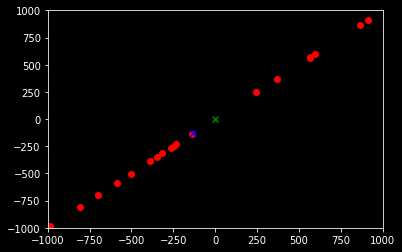

In [230]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_5[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_5 = np.mean(error[:,0])
mean_var_error_dt_scaled_5 =np.mean(var[:,0])

### Omit body_type variable

In [231]:
# check col indexes
print(col_names5[0] , "/", col_names5[7])

body_type_Coupe / body_type_Wagon


In [232]:
print(col_names5[0:7+1])

['body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon']


In [22]:
# omit columns
col_names6 = copy.deepcopy(col_names5)
start_idx, end_idx = 0,7
x_test_scaled6 = omit_var(start_idx, end_idx, x_test_scaled5)
x_train_scaled6 = omit_var(start_idx, end_idx, x_train_scaled5)
x_val_scaled6 = omit_var(start_idx, end_idx, x_val_scaled5)

remove = ['body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon']
for i in remove:
    col_names6.remove(i)
omitted_cols += [(start_idx, end_idx)]

In [234]:
x_train_scaled6.shape

(952025, 124)

##### Run DT Regression

In [235]:
dt_scaled_6 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_6.fit(x_train_scaled6, y_train)

DecisionTreeRegressor(random_state=2023)

In [236]:
y_pred_dt_scaled_6 = dt_scaled_6.predict(x_val_scaled6)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_6)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_6))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_6))

RMSE: 5709.588405
R^2: 0.867421
MAPE: 0.116036


Mean Error, x = -199.492542  y = -199.492542
Mean Var Error, x = 18909347.452000  y = 18909347.452000


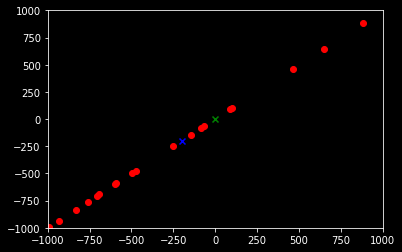

In [237]:
# Create Bias-Variance graph 

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_6[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_6 = np.mean(error[:,0])
mean_var_error_dt_scaled_6 =np.mean(var[:,0])

### Omit listing_colour variable

In [238]:
# check col indexes
print(col_names6[1] , "/", col_names6[14])

listing_color_BLUE / listing_color_YELLOW


In [239]:
print(col_names6[1:14+1])

['listing_color_BLUE', 'listing_color_BROWN', 'listing_color_GOLD', 'listing_color_GRAY', 'listing_color_GREEN', 'listing_color_ORANGE', 'listing_color_PINK', 'listing_color_PURPLE', 'listing_color_RED', 'listing_color_SILVER', 'listing_color_TEAL', 'listing_color_UNKNOWN', 'listing_color_WHITE', 'listing_color_YELLOW']


In [23]:
# omit columns
col_names7 = copy.deepcopy(col_names6)
start_idx, end_idx = 1,14
x_test_scaled7 = omit_var(start_idx, end_idx, x_test_scaled6)
x_train_scaled7 = omit_var(start_idx, end_idx, x_train_scaled6)
x_val_scaled7 = omit_var(start_idx, end_idx, x_val_scaled6)

remove =['listing_color_BLUE', 'listing_color_BROWN', 'listing_color_GOLD', 'listing_color_GRAY', 'listing_color_GREEN', 'listing_color_ORANGE', 'listing_color_PINK', 'listing_color_PURPLE', 'listing_color_RED', 'listing_color_SILVER', 'listing_color_TEAL', 'listing_color_UNKNOWN', 'listing_color_WHITE', 'listing_color_YELLOW']
for i in remove:
    col_names7.remove(i)
omitted_cols += [(start_idx, end_idx)]

In [24]:
x_train_scaled7.shape

(952025, 110)

In [25]:
len(col_names7)

110

##### Run DT Regression

In [24]:
dt_scaled_7 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_7.fit(x_train_scaled7, y_train)

DecisionTreeRegressor(random_state=2023)

In [27]:
y_pred_dt_scaled_7 = dt_scaled_7.predict(x_val_scaled7)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_7)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_7))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_7))

RMSE: 5709.268383
R^2: 0.867436
MAPE: 0.115330


Mean Error, x = -150.468739  y = -150.468739
Mean Var Error, x = 20881410.958403  y = 20881410.958403


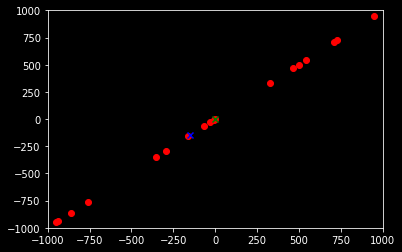

In [28]:
# Create Bias-Variance graph 

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_7[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_7 = np.mean(error[:,0])
mean_var_error_dt_scaled_7 =np.mean(var[:,0])

### Omit state variable

In [246]:
# check col indexes
print(col_names7[56] , "/", col_names7[105])

state_Alaska / state_Wyoming


In [247]:
# omit columns
col_names8 = copy.deepcopy(col_names7)
start_idx, end_idx = 56,105
x_test_scaled8 = omit_var(start_idx, end_idx, x_test_scaled7)
x_train_scaled8 = omit_var(start_idx, end_idx, x_train_scaled7)
x_val_scaled8 = omit_var(start_idx, end_idx, x_val_scaled7)

del col_names8[start_idx : end_idx+1]

In [248]:
x_val_scaled7.shape

(317342, 110)

##### Run DT Regression

In [249]:
dt_scaled_8 = tree.DecisionTreeRegressor(random_state = random_state)
dt_scaled_8.fit(x_train_scaled8, y_train)

DecisionTreeRegressor(random_state=2023)

In [250]:
y_pred_dt_scaled_8 = dt_scaled_8.predict(x_val_scaled8)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_8)))
print("R^2: %.6f" % metrics.r2_score(y_val, y_pred_dt_scaled_8))
print("MAPE: %.6f" % mape(y_val, y_pred_dt_scaled_8))

RMSE: 5889.716837
R^2: 0.858924
MAPE: 0.122303


Mean Error, x = -284.397413  y = -284.397413
Mean Var Error, x = 23157218.678678  y = 23157218.678678


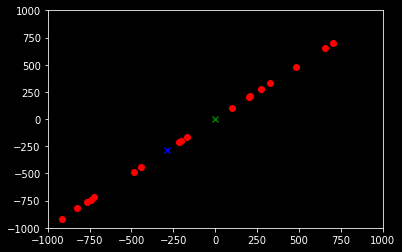

In [251]:
# Create Bias-Variance graph 

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_val[select_index[i]] - y_pred_dt_scaled_8[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaled_8 = np.mean(error[:,0])
mean_var_error_dt_scaled_8 =np.mean(var[:,0])

NOTE: Removal of state leads to increase in MAPE although RMSE drops.

## Plot RMSE, MPSE, R^2, Mean Error & Mean Var Error (from Bias-Variance graphs) changes as variables are dropped

In [252]:
models = ['dt_scaled','dt_scaled_2','dt_scaled_3','dt_scaled_4', 'dt_scaled_5', 'dt_scaled_6', 'dt_scaled_7','dt_scaled_8']

RMSE = [np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_2)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_3)),
        np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_4)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_5)), np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_6)), 
        np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_7)),np.sqrt(metrics.mean_squared_error(y_val, y_pred_dt_scaled_8))]

R2 = [metrics.r2_score(y_val, y_pred_dt_scaled), metrics.r2_score(y_val, y_pred_dt_scaled_2), metrics.r2_score(y_val, y_pred_dt_scaled_3), metrics.r2_score(y_val, y_pred_dt_scaled_4),
      metrics.r2_score(y_val, y_pred_dt_scaled_5), metrics.r2_score(y_val, y_pred_dt_scaled_6),  metrics.r2_score(y_val, y_pred_dt_scaled_7), metrics.r2_score(y_val, y_pred_dt_scaled_8)]

MAPE = [mape(y_val, y_pred_dt_scaled), mape(y_val, y_pred_dt_scaled_2), mape(y_val, y_pred_dt_scaled_3), mape(y_val, y_pred_dt_scaled_4), mape(y_val, y_pred_dt_scaled_5),
        mape(y_val, y_pred_dt_scaled_6),mape(y_val, y_pred_dt_scaled_7),mape(y_val, y_pred_dt_scaled_8)]

mean_error_BV = [abs(mean_error_dt_scaled), abs(mean_error_dt_scaled_2), abs(mean_error_dt_scaled_3), abs(mean_error_dt_scaled_4), abs(mean_error_dt_scaled_5),
                 abs(mean_error_dt_scaled_6),abs(mean_error_dt_scaled_7),abs(mean_error_dt_scaled_8)]

mean_var_error_BV = [mean_var_error_dt_scaled, mean_var_error_dt_scaled_2, mean_var_error_dt_scaled_3, mean_var_error_dt_scaled_4, mean_var_error_dt_scaled_5, mean_var_error_dt_scaled_6,
                     mean_var_error_dt_scaled_7,mean_var_error_dt_scaled_8]


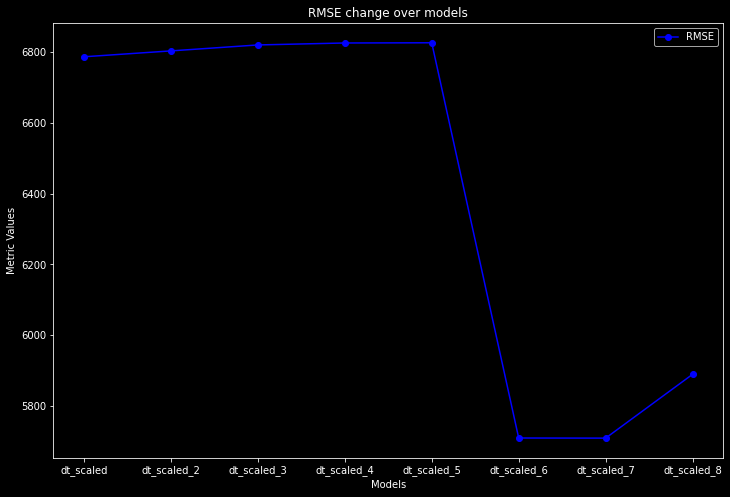

In [253]:
plt.figure(figsize = (12, 8))
plt.plot(models, RMSE, 'bo-', label = 'RMSE')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('RMSE change over models')
plt.legend()
plt.show()

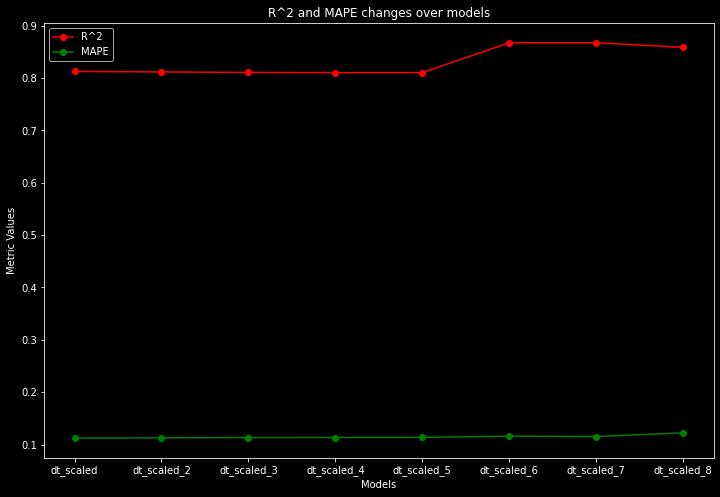

In [254]:
plt.figure(figsize = (12, 8))
plt.plot(models, R2, 'ro-', label = 'R^2')
plt.plot(models, MAPE, 'go-', label = 'MAPE')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('R^2 and MAPE changes over models')
plt.legend()
plt.show()

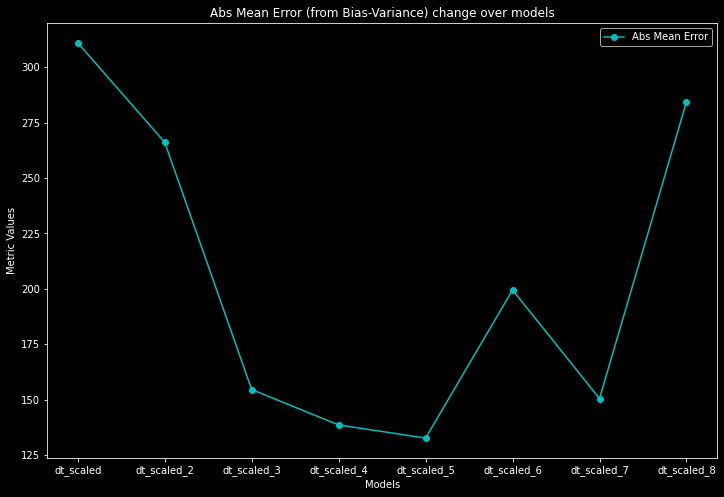

In [255]:
plt.figure(figsize = (12, 8))
plt.plot(models, mean_error_BV, 'co-', label = 'Abs Mean Error')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Abs Mean Error (from Bias-Variance) change over models')
plt.legend()
plt.show()

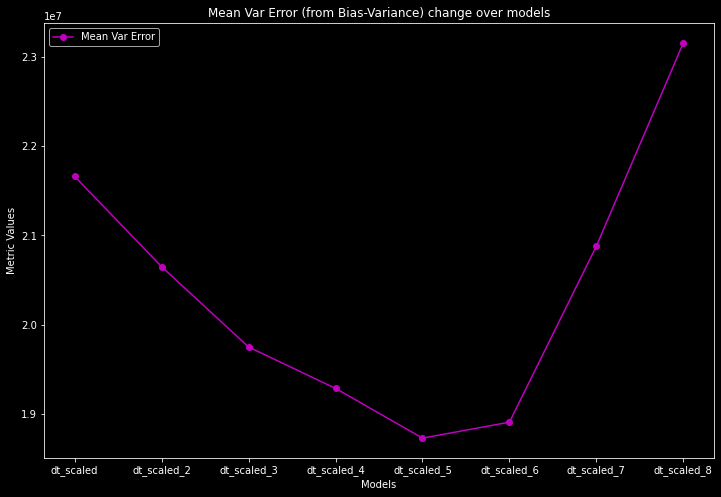

In [256]:
plt.figure(figsize = (12, 8))
plt.plot(models, mean_var_error_BV, 'mo-', label = 'Mean Var Error')
plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Mean Var Error (from Bias-Variance) change over models')
plt.legend()
plt.show()

## Run dt_scaled_7 on Test data

In [26]:
y_pred_dt_scaled_7_TEST = dt_scaled_7.predict(x_test_scaled7)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt_scaled_7_TEST)))
print("R^2: %.6f" % metrics.r2_score(y_test, y_pred_dt_scaled_7_TEST))
print("MAPE: %.6f" % mape(y_test, y_pred_dt_scaled_7_TEST))

RMSE: 5255.187411
R^2: 0.884307
MAPE: 0.120290


Mean Error, x = -43.081869  y = -43.081869
Mean Var Error, x = 24390248.592888  y = 24390248.592888


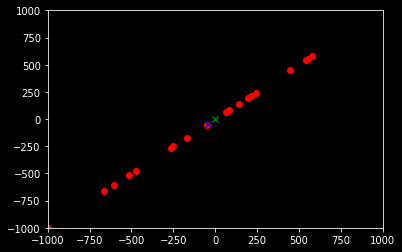

In [30]:
# Create Bias-Variance graph for dt_notscaled

error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_test[select_index[i]] - y_pred_dt_scaled_7_TEST[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_dt_scaledstd_7_TEST = np.mean(error[:,0])
mean_var_error_dt_scaledstd_7_TEST =np.mean(var[:,0])

In [31]:
print(col_names7)

['is_new_True', 'make_name_Alfa Romeo', 'make_name_Aston Martin', 'make_name_Audi', 'make_name_BMW', 'make_name_Bentley', 'make_name_Buick', 'make_name_Cadillac', 'make_name_Chevrolet', 'make_name_Chrysler', 'make_name_Dodge', 'make_name_FIAT', 'make_name_Ford', 'make_name_GMC', 'make_name_Genesis', 'make_name_Honda', 'make_name_Hummer', 'make_name_Hyundai', 'make_name_INFINITI', 'make_name_Isuzu', 'make_name_Jaguar', 'make_name_Jeep', 'make_name_Kia', 'make_name_Land Rover', 'make_name_Lexus', 'make_name_Lincoln', 'make_name_MINI', 'make_name_Maserati', 'make_name_Mazda', 'make_name_Mercedes-Benz', 'make_name_Mercury', 'make_name_Mitsubishi', 'make_name_Nissan', 'make_name_Oldsmobile', 'make_name_Plymouth', 'make_name_Pontiac', 'make_name_Porsche', 'make_name_RAM', 'make_name_Rolls-Royce', 'make_name_Saab', 'make_name_Saturn', 'make_name_Scion', 'make_name_Subaru', 'make_name_Suzuki', 'make_name_Toyota', 'make_name_Volkswagen', 'make_name_Volvo', 'maximum_seating_4 seats', 'maximum_se

In [32]:
print("Final Variables: ")
print("is_new_True,make_name (encoded), maximum_seating (4,5,6,7,8) (encoded), wheel_system (encooded),")
print("state (encoded), daysonmarket, horsepower, mileage, seller_rating")


Final Variables: 
is_new_True,make_name (encoded), maximum_seating (4,5,6,7,8) (encoded), wheel_system (encooded),
state (encoded), daysonmarket, horsepower, mileage, seller_rating


### Run K-Fold

In [39]:
# Copy model so code uses 1 object only 
kf_model = copy.deepcopy(dt_scaled_7)

# Prep data
print(omitted_cols)


[(88, 90), (12, 16), (82, 82), (73, 76), (8, 11), (0, 7), (1, 14)]


In [40]:
#Prep data
kf  = KFold(n_splits = 10, shuffle = True, random_state = random_state)

x_kf = copy.deepcopy(x)

for indexes in omitted_cols:
    start_idx, end_idx = indexes[0], indexes[1]
    x_kf = omit_var(start_idx, end_idx, x_kf)

x_kf = scaling(x_kf,y)

In [263]:
#Run k-fold
print('RUN K-FOLD, splits = 10, shuffle = True')

final_scores_cross_val_R2 = cross_val_score(kf_model, x_kf, y, scoring='r2', cv=kf, n_jobs=1)


RUN K-FOLD, splits = 10, shuffle = True


In [264]:
print('R^2:')
for i in final_scores_cross_val_R2:
    print('%5f' % i)

R^2:
0.886712
0.906005
0.720425
0.889065
0.912900
0.811977
0.861047
0.907720
0.789380
0.769850


In [265]:
def mape_kfold(estimator, x, y):
    predicted = estimator.predict(x)
    return sum(abs((y - predicted) / y)) / len(y)

In [266]:
#Run k-fold
print('RUN K-FOLD, splits = 10, shuffle = True')

final_scores_cross_val_MAPE = cross_val_score(kf_model, x_kf, y, scoring=mape_kfold, cv=kf, n_jobs=1)


RUN K-FOLD, splits = 10, shuffle = True


In [267]:
print('MAPE:')
for i in final_scores_cross_val_MAPE:
    print('%5f' % i)

MAPE:
0.099716
0.099765
0.100393
0.099724
0.100183
0.099778
0.100448
0.100382
0.100623
0.100437


## Save Decision Tree model to a file for future use

In [37]:
import joblib

#### Save file

In [38]:
# Save the decision tree model 
joblib.dump(dt_scaled_7, 'AML_final_DT.joblib')

['AML_final_DT.joblib']

In [40]:
# Save test data to run testing on model imported
np.savetxt('AML_scaledData_forDT_xTest.csv', x_test_scaled7, delimiter=',')
np.savetxt('AML_Data_forDT_yTest.csv', y_test, delimiter=',')

#### Save DT as image

In [46]:
from sklearn.tree import export_graphviz

export_graphviz(dt_scaled_7, out_file='AML_final_DT_img.dot', 
                feature_names=col_names7, 
                class_names='Price', 
                filled=True, rounded=True, special_characters=True)

In [48]:
import pydot

(graph,) = pydot.graph_from_dot_file('AML_final_DT_img.dot')
graph.write_png('AML_final_DT_img.png')

#### Import file and test

In [ ]:
import joblib

In [43]:
loaded_DT = joblib.load('AML_final_DT.joblib')
loaded_scaled_xTest = np.loadtxt('AML_scaledData_forDT_xTest.csv', delimiter=',')
loaded_yTest = np.loadtxt('AML_Data_forDT_yTest.csv', delimiter=',')

In [44]:
predicted_LoadedDT = loaded_DT.predict(loaded_scaled_xTest)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(loaded_yTest, predicted_LoadedDT)))
print("R^2: %.6f" % metrics.r2_score(loaded_yTest, predicted_LoadedDT))
print("MAPE: %.6f" % mape(loaded_yTest, predicted_LoadedDT))

RMSE: 5255.187411
R^2: 0.884307
MAPE: 0.120290


# Run MLR to valdiate features omitted

In [33]:
import statsmodels.api as sm
def get_stats(x,y):
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [34]:
print('Run MLR on data with all columns')
print('\r')
get_stats(x_train_scaled,y_train)

Run MLR on data with all columns

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.159
Model:                            OLS   Adj. R-squared (uncentered):              0.158
Method:                 Least Squares   F-statistic:                              1212.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:43:10   Log-Likelihood:                     -1.1226e+07
No. Observations:              952025   AIC:                                  2.245e+07
Df Residuals:                  951877   BIC:                                  2.245e+07
Df Model:                         148                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------

In [35]:
print('Run MLR on data with columns in dt_scaled_7')
print('\r')
get_stats(x_train_scaled7,y_train)

Run MLR on data with columns in dt_scaled_7

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.156
Model:                            OLS   Adj. R-squared (uncentered):              0.156
Method:                 Least Squares   F-statistic:                              1617.
Date:                Mon, 20 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:43:39   Log-Likelihood:                     -1.1227e+07
No. Observations:              952025   AIC:                                  2.245e+07
Df Residuals:                  951916   BIC:                                  2.246e+07
Df Model:                         109                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.9

# Run Gradient Boosted Regression model

In [36]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


In [37]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mape',
    'learning_rate': 0.3,
    'lambda' : 2,
    'n_estimators': 300
}

pipe = make_pipeline(
    XGBRegressor(tree_method='gpu_hist', **params)
)

param_grid = {
    'xgbregressor__n_estimators': [200, 300, 400, 500],
    'xgbregressor__learning_rate': [0.001, 0.01, 0.1, 0.2]
}
cv = KFold(n_splits=10, shuffle=True, random_state=random_state)

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='neg_mean_absolute_percentage_error')

In [41]:
grid.fit(x_kf, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=2023, shuffle=True),
             estimator=Pipeline(steps=[('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric='mape',
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     gro

In [42]:
best_estimator = grid.best_estimator_
print("Best hyperparameters: ", grid.best_params_)

Best hyperparameters:  {'xgbregressor__learning_rate': 0.2, 'xgbregressor__n_estimators': 500}


In [44]:
y_pred_XGBoost_scaled = best_estimator.predict(x_test_scaled7)

print("RMSE: %.6f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred_XGBoost_scaled)))
print("R^2: %.6f" % metrics.r2_score(y_test, y_pred_XGBoost_scaled))
print("MAPE: %.6f" % mape(y_test, y_pred_XGBoost_scaled))

RMSE: 10516.080664
R^2: 0.536724
MAPE: 0.177819


## Multilinear Regression

Will only be running robust scaled data

In [52]:
cars_impt = cars_dataset.copy(deep=True)

# define words to match at beginning of column names
words_to_match = ['transmission', 'fuel_type', 'maximum_seating', 'engine_type', 'body_type', 'listing_color']

# drop columns that match each word
def drop_cols(df):
    pattern = re.compile('|'.join(words_to_match)) # compile regex pattern
    matching_cols = [col for col in df.columns if not pattern.search(col)] # extract columns from dataframe that match regex pattern
    new_df = df[matching_cols]
    return new_df

df1 = drop_cols(cars_impt)

In [53]:
# Split as train and test only since hyperparameter tuning will not be taking place for MLR as it was conducted in earlier models

cars_array, col_names = process(cars_impt)

random_state = 2023

x =  cars_array[:, :-1]
y =  cars_array[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=random_state)

# Validate size (as %) of sets
print("Train size: %.3f" % (x_train.shape[0]/ x.shape[0]))
print("Test size: %.3f" % (x_test.shape[0]/ x.shape[0]))

x_train_scaledstd = scaling_std(x_train, y_train)
x_test_scaledstd = scaling_std(x_test, y_test)

regr = linear_model.LinearRegression()
regr.fit(x_train_scaledstd, y_train)

y_pred_test = regr.predict(x_test_scaledstd)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mape_test = mape(y_test, y_pred_test)

print("Test RMSE: ", rmse_test)
print("Test R^2: ", r2_test)
print("Test MAPE: ", mape_test)

len(col_names) = 150
Train size: 0.700
Test size: 0.300
Test RMSE:  1884297495871.662
Test R^2:  -1.4739778662017116e+16
Test MAPE:  1289744.4971382043


Mean Error, x = -48.575528  y = -48.575528
Mean Var Error, x = 38118523.446206  y = 38118523.446206


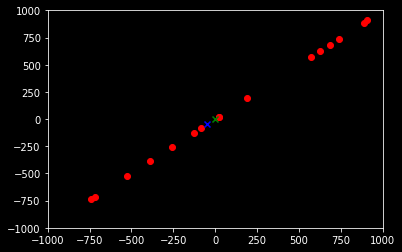

In [54]:
# Prep for BV-graph
plotsize = (-300,300)

# Create Bias-Variance graph for dt_notscaled
error = np.zeros((num_test, 2))
var = np.zeros((num_test, 2))
for i in range(num_test):
    err = y_test[select_index[i]] - y_pred_test[select_index[i]]
    error[i,:] = np.mean(err, axis = 0)
    var[i,:] = np.var(err, axis = 0)


plt.subplot(1,1,1)
plt.scatter(error[:,0], error[:,1], color = 'red')
plt.scatter(np.mean(error[:,0]), np.mean(error[:,1]), marker = 'x', color = 'blue')
plt.scatter(0.0, 0.0, marker = 'x', color = 'green')
plt.xlim(standard_plot_size[0], standard_plot_size[1])
plt.ylim(standard_plot_size[0], standard_plot_size[1])

print("Mean Error, x = %.6f" % np.mean(error[:,0])," y = %.6f" % np.mean(error[:,1])  )
print("Mean Var Error, x = %.6f" % np.mean(var[:,0])," y = %.6f" % np.mean(var[:,1])  )

mean_error_mlr_scaledstd = np.mean(error[:,0])
mean_var_error_mlr_scaledstd =np.mean(var[:,0])

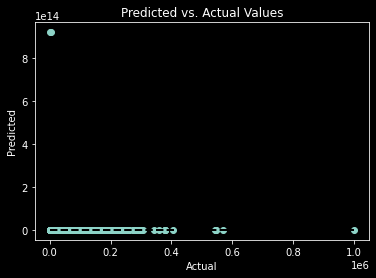

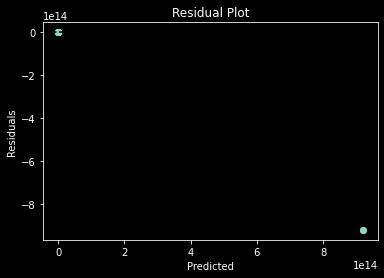

In [55]:
# Plot the predicted vs. actual values
plt.scatter(y_test, y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plot the 45 degree line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual Values')
plt.show()

# Plot the residuals
plt.scatter(y_pred_test, y_test - y_pred_test)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

### Regularisation - Lasso/Ridge

In [56]:
# Lasso
alpha = [0.001, 0.01, 0.1, 1, 10]

for i in range(5):
    lasso = linear_model.Lasso(alpha[i])
    lasso.fit(x_train_scaledstd, y_train)
    y_pred_test_lasso = lasso.predict(x_test_scaledstd)
    lasso_cplxy = np.linalg.norm(lasso.coef_, ord = 1)
    
    mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
    rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_test_lasso))
    r2_test_lasso = r2_score(y_test, y_pred_test_lasso)
    mape_test_lasso = mape(y_test, y_pred_test_lasso)
    
    print('-' * 40)
    print('alpha =', alpha[i])
    print('score:', lasso.score(x_test_scaledstd, y_test))
    print("Lasso Test RMSE: ", rmse_test_lasso)
    print("Lasso Test R^2: ", r2_test_lasso)
    print("Lasso Test MAPE: ", mape_test_lasso)
    print('model complexity:', lasso_cplxy)
    print('regularized cost:', mse_test_lasso + alpha[i] * lasso_cplxy)

c:\Users\Amanda Faith Lau\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.178e+13, tolerance: 2.776e+10
  model = cd_fast.enet_coordinate_descent(


----------------------------------------
alpha = 0.001
score: 0.799383386161181
Lasso Test RMSE:  6951.642630519064
Lasso Test R^2:  0.799383386161181
Lasso Test MAPE:  0.17952889691563595
model complexity: 769897.8560206093
regularized cost: 48326105.16030604


c:\Users\Amanda Faith Lau\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e+13, tolerance: 2.776e+10
  model = cd_fast.enet_coordinate_descent(


----------------------------------------
alpha = 0.01
score: 0.7993794837871556
Lasso Test RMSE:  6951.710241513974
Lasso Test R^2:  0.7993794837871556
Lasso Test MAPE:  0.17953485960586252
model complexity: 751747.7603007483
regularized cost: 48333792.759573296


c:\Users\Amanda Faith Lau\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e+13, tolerance: 2.776e+10
  model = cd_fast.enet_coordinate_descent(


----------------------------------------
alpha = 0.1
score: 0.799334834929317
Lasso Test RMSE:  6952.483763237219
Lasso Test R^2:  0.799334834929317
Lasso Test MAPE:  0.17956690063895409
model complexity: 690752.4421569183
regularized cost: 48406105.722292855
----------------------------------------
alpha = 1
score: 0.7986748450240561
Lasso Test RMSE:  6963.907774791882
Lasso Test R^2:  0.7986748450240561
Lasso Test MAPE:  0.17975062730596564
model complexity: 536381.2549196549
regularized cost: 49032392.75072647
----------------------------------------
alpha = 10
score: 0.7873768343530643
Lasso Test RMSE:  7156.641786413041
Lasso Test R^2:  0.7873768343530643
Lasso Test MAPE:  0.18127063564929793
model complexity: 287722.7578460085
regularized cost: 54094749.23749332


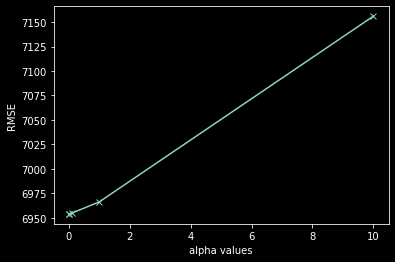

In [57]:
# Plot Lasso RMSE
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values = [6953.93, 6954.00, 6954.79, 6966.27, 7155.99]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot a line chart with the given x and y values
ax.plot(x_values, y_values, 'x-')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('RMSE')

# Show the plot
plt.show()

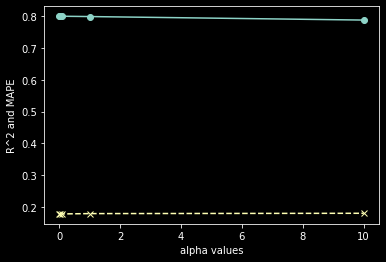

In [58]:
# Plot Lasso R^2 and MAPE
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values1 = [0.799, 0.799, 0.799, 0.798, 0.787]
y_values2 = [0.179, 0.179, 0.179, 0.180, 0.181]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot two lines with markers and the given x and y values
ax.plot(x_values, y_values1, 'o-', label='R^2')
ax.plot(x_values, y_values2, 'x--', label='MAPE')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('R^2 and MAPE')

# Show the plot
plt.show()

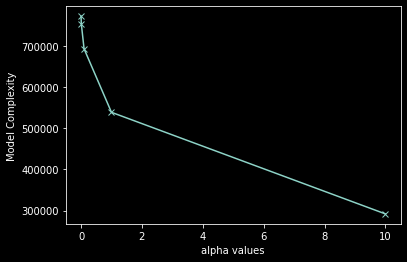

In [59]:
# Plot Model Complexity
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values = [772988, 754598, 693791, 539137, 291756]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot a line chart with the given x and y values
ax.plot(x_values, y_values, 'x-')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('Model Complexity')

# Show the plot
plt.show()

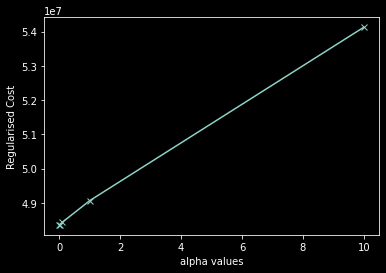

In [60]:
# Plot Regularized Cost
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values = [48358015, 48365745, 48438573, 49068107, 54125883]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot a line chart with the given x and y values
ax.plot(x_values, y_values, 'x-')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('Regularised Cost')

# Show the plot
plt.show()

In [61]:
# Ridge
alpha = [0.001, 0.01, 0.1, 1, 10]

for i in range(5):
    ridge = linear_model.Ridge(alpha[i])
    ridge.fit(x_train_scaledstd, y_train)
    y_pred_test_ridge = ridge.predict(x_test_scaledstd)
    ridge_cplxy = np.linalg.norm(ridge.coef_, ord = 1)
    
    mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
    rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_pred_test_ridge))
    r2_test_ridge = r2_score(y_test, y_pred_test_ridge)
    mape_test_ridge = mape(y_test, y_pred_test_ridge)
    
    print('-' * 40)
    print('alpha =', alpha[i])
    print('score:', ridge.score(x_test_scaledstd, y_test))
    print("Ridge Test RMSE: ", rmse_test_ridge)
    print("Ridge Test R^2: ", r2_test_ridge)
    print("Ridge Test MAPE: ", mape_test_ridge)
    print('model complexity:', ridge_cplxy)
    print('regularized cost:', mse_test_ridge + alpha[i] * ridge_cplxy)

----------------------------------------
alpha = 0.001
score: 0.7993919198913177
Ridge Test RMSE:  6951.494776181475
Ridge Test R^2:  0.7993919198913177
Ridge Test MAPE:  0.1795279698345432
model complexity: 819891.524844992
regularized cost: 48324099.51480318
----------------------------------------
alpha = 0.01
score: 0.7993917487052145
Ridge Test RMSE:  6951.49774216133
Ridge Test R^2:  0.7993917487052145
Ridge Test MAPE:  0.17952807971697404
model complexity: 819585.0461220022
regularized cost: 48331516.7097353
----------------------------------------
alpha = 0.1
score: 0.7993900159786604
Ridge Test RMSE:  6951.527763405825
Ridge Test R^2:  0.7993900159786604
Ridge Test MAPE:  0.17952917800411006
model complexity: 816592.0612902249
regularized cost: 48405397.451531015
----------------------------------------
alpha = 1
score: 0.7993708853332542
Ridge Test RMSE:  6951.859212618035
Ridge Test R^2:  0.7993708853332542
Ridge Test MAPE:  0.17954045441176458
model complexity: 793289.83554

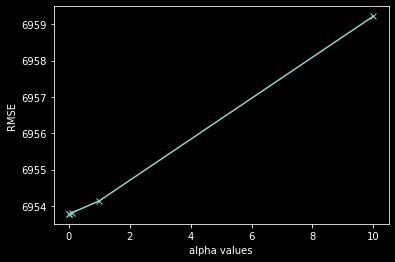

In [62]:
# Plot Ridge RMSE
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values = [6953.78, 6953.78, 6953.81, 6954.14, 6959.22]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot a line chart with the given x and y values
ax.plot(x_values, y_values, 'x-')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('RMSE')

# Show the plot
plt.show()

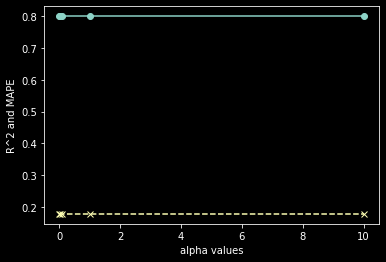

In [63]:
# Plot Ridge R^2 and MAPE
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values1 = [0.799, 0.799, 0.799, 0.799, 0.799]
y_values2 = [0.179, 0.179, 0.179, 0.179, 0.179]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot two lines with markers and the given x and y values
ax.plot(x_values, y_values1, 'o-', label='R^2')
ax.plot(x_values, y_values2, 'x--', label='MAPE')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('R^2 and MAPE')

# Show the plot
plt.show()

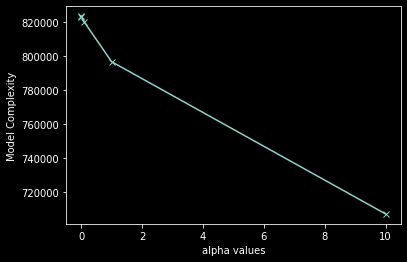

In [64]:
# Plot Model Complexity
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values = [823560, 823252, 820246, 796805, 707171]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot a line chart with the given x and y values
ax.plot(x_values, y_values, 'x-')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('Model Complexity')

# Show the plot
plt.show()

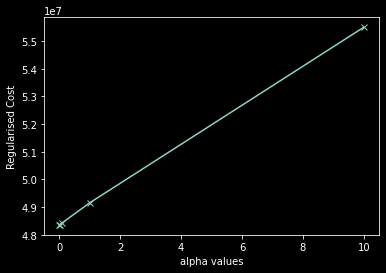

In [65]:
# Plot Regularized Cost
x_values = [0.001, 0.01, 0.1, 1, 10]
y_values = [48355971, 48363421, 48437625, 49156958, 55502534]

# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot a line chart with the given x and y values
ax.plot(x_values, y_values, 'x-')

# Set the x and y axis labels
ax.set_xlabel('alpha values')
ax.set_ylabel('Regularised Cost')

# Show the plot
plt.show()